In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import mibian

/tmp/ipykernel_261072/1903986562.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def add_delta(data):
    data['Maturity'] = data['time_to_maturity'] * 365
    for index, row in data.iterrows():
        # Assuming 365 days per year and interest rates are expressed as percentages
        bs = mibian.BS([row['selected_spot_price'], row['strike'], row['interest_rate'], row['Maturity']], 
                       volatility=row['lyra_IV'])
        data.at[index, 'delta'] = abs(bs.callDelta) if row['type'] == 'call' else abs(bs.putDelta)
    return data

eth = add_delta(pd.read_csv('../data processing/deribit lyra comparison/eth.csv'))

In [3]:
# Convert date columns to datetime if not already
eth['date'] = pd.to_datetime(eth['date'])
eth['datetime'] = pd.to_datetime(eth['datetime'])
eth['expiry'] = pd.to_datetime(eth['expiry'])
# Calculate moneyness as strike/spot price
eth['Moneyness'] = eth.apply(lambda row: row['strike'] / row['selected_spot_price'] if row['type'] == 'call' else row['selected_spot_price'] / row['strike'], axis=1)
# Filter data by maturity (7 and 15 days)
eth['time_to_maturity_days'] = (eth['expiry'] - eth['date']).dt.days
# Calculate week number from the start of the sample period
eth['Week'] = (eth['date'] - eth['date'].min()).dt.days // 7
# save a new column as the date that represent the Week number column
eth['Week'] = eth.groupby('Week')['date'].transform('first')


In [4]:
def trading_strategy(row):
    # Sell Lyra options and buy Deribit options when Lyra IV is higher than Deribit IV
    # if row['lyra_IV'] > row['selected_deribit_IV']:
    pnl = (row['selected_deribit_price'] - row['lyra_price']) / row['selected_spot_price']
    # else:
    #     pnl = 0  # Do not engage in reverse trades
    return pnl

# Apply the trading strategy to each row
eth['PnL'] = eth.apply(trading_strategy, axis=1)

In [19]:
pnl_data = eth[eth['PnL'] != 0][['Week', 'PnL', 'Moneyness', 'time_to_maturity_days', 'type', 'date', 'delta']]
# Function to categorize moneyness
def categorize_moneyness(value):
    if value < 0.95:
        return 'Below ATM'
    elif 0.95 <= value <= 1.05:
        return 'ATM'
    else:
        return 'Above ATM'

# Function to categorize maturity days
def categorize_maturity(days):
    if days <= 21:
        return '0-3 weeks'
    elif 21 < days <= 49:
        return '3-7 weeks'
    elif 50 <= days:
        return 'more than 7 weeks'
    
# Apply categorization
pnl_data['Moneyness Category'] = pnl_data['Moneyness'].apply(categorize_moneyness)
pnl_data['Maturity Category'] = pnl_data['time_to_maturity_days'].apply(categorize_maturity)

In [20]:
# Enhanced plotting function
def plot_cumulative_pnl(ax, data, title, linestyle, color):
    weekly_pnl = data.groupby('Week')['PnL'].sum()
    cumulative_pnl = weekly_pnl.cumsum()
    ax.plot(cumulative_pnl.index, cumulative_pnl, label=title, linestyle=linestyle, color=color, linewidth=2)

In [21]:
def plot_mness_category(data):
    fig, ax = plt.subplots(figsize=(6, 4))

    # Define styles for each line
    styles = {
        'ATM': {'linestyle': '-', 'color': 'lightblue', 'title': '0.95 <= Moneyness <= 1.05'},
        'Above ATM': {'linestyle': '--', 'color': 'lightgreen', 'title': 'Moneyness > 1.05'},
        'Below ATM': {'linestyle': '-.', 'color': 'red', 'title': 'Moneyness < 0.95'}
    }

    # Plotting different categories
    for category, style in styles.items():
        subset = data[data['Moneyness Category'] == category]
        if not subset.empty:
            plot_cumulative_pnl(ax, subset, f'{styles[category]["title"]}', style['linestyle'], style['color'])

    # Setting labels and titles
    ax.set_xlabel('Date')
    ax.set_ylabel('P&L')
    ax.legend()

    # Formatting the date axis
    # Format the x-axis to handle date data
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))  # Set major ticks to Mondays
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format the dates as YYYY-MM-DD

    ax.grid(True)  # Enable grid for better readability

    # Rotate date labels for better visibility
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels
    plt.show()

In [22]:
def plot_type_category(data):
    fig, ax = plt.subplots(figsize=(6, 4))

    # Define styles for each line
    styles = {
        'call': {'linestyle': '-', 'color': 'lightblue', 'title': 'Call'},
        'put': {'linestyle': '--', 'color': 'lightgreen', 'title': 'Put'}
    }

    # Plotting different categories
    for category, style in styles.items():
        subset = data[data['type'] == category]
        if not subset.empty:
            plot_cumulative_pnl(ax, subset, f'{styles[category]["title"]}', style['linestyle'], style['color'])

    # Setting labels and titles
    ax.set_xlabel('Date')
    ax.set_ylabel('P&L')
    ax.legend()

    # Formatting the date axis
    # Format the x-axis to handle date data
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))  # Set major ticks to Mondays
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format the dates as YYYY-MM-DD

    ax.grid(True)  # Enable grid for better readability

    # Rotate date labels for better visibility
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels
    plt.show()

In [26]:
def check_coverage(data):
    # Check each week for coverage in all categories
    coverage = data.groupby('Week')['Maturity Category'].nunique()
    return coverage[coverage < 2].index.min()  # Return the first week where not all categories are covered

def plot_maturity_category(data):
    fig, ax = plt.subplots(figsize=(6, 4))

    # Define new maturity categories
    bins = [0, 30, float('inf')]
    labels = ['Short-term (less than a month)', 'Long-term (more than a month)']
    data['Maturity Category'] = pd.cut(data['time_to_maturity_days'], bins=bins, labels=labels, right=False)

    # Define styles for each line
    styles = {
        'Short-term (less than a month)': {'linestyle': '-', 'color': 'lightblue'},
        'Long-term (more than a month)': {'linestyle': '--', 'color': 'lightgreen'}
    }

    # Plotting for each maturity category
    for category, style in styles.items():
        subset = data[data['Maturity Category'] == category]
        if not subset.empty:
            plot_cumulative_pnl(ax, subset, category, style['linestyle'], style['color'])

    # cut from July first

    # Setting labels and titles
    ax.set_xlabel('Date')
    ax.set_ylabel('Cumulative P&L')
    ax.legend()

    # Date formatting
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.grid(True)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    plt.tight_layout()
    plt.show()

In [27]:
# create plot for delta
def plot_delta(data):
    fig, ax = plt.subplots(figsize=(6, 4))

    # Define new delta categories
    bins = [0, 0.5, 1]
    labels = ['Low Delta (0-0.5)', 'High Delta (0.5-1)']
    data['Delta Category'] = pd.cut(data['delta'], bins=bins, labels=labels, right=False)

    # Define styles for each line
    styles = {
        'Low Delta (0-0.5)': {'linestyle': '-', 'color': 'lightblue'},
        'High Delta (0.5-1)': {'linestyle': '--', 'color': 'lightgreen'}
    }

    # Plotting for each delta category
    for category, style in styles.items():
        subset = data[data['Delta Category'] == category]
        if not subset.empty:
            plot_cumulative_pnl(ax, subset, category, style['linestyle'], style['color'])

    # Setting labels and titles
    ax.set_xlabel('Date')
    ax.set_ylabel('Cumulative P&L')
    ax.legend()

    # Date formatting
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.grid(True)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_261072/63996585.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Delta Category'] = pd.cut(data['delta'], bins=bins, labels=labels, right=False)


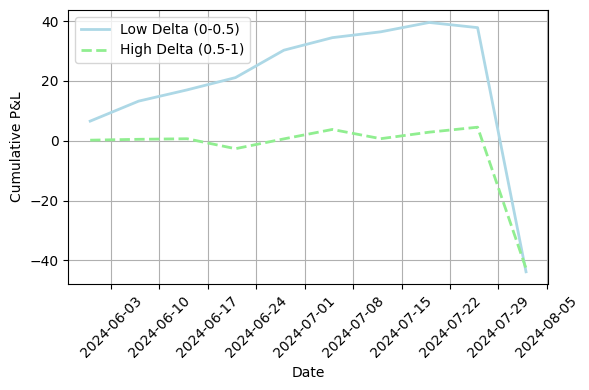

/tmp/ipykernel_261072/1997480582.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Maturity Category'] = pd.cut(data['time_to_maturity_days'], bins=bins, labels=labels, right=False)


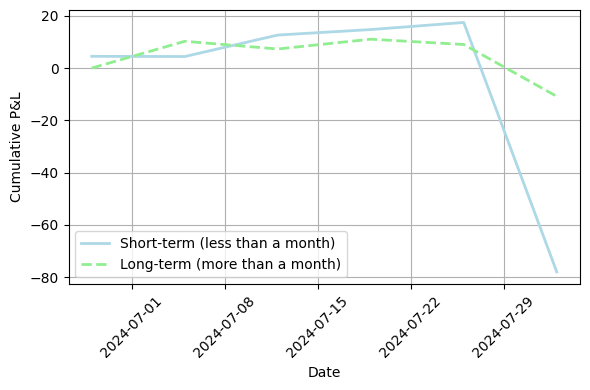

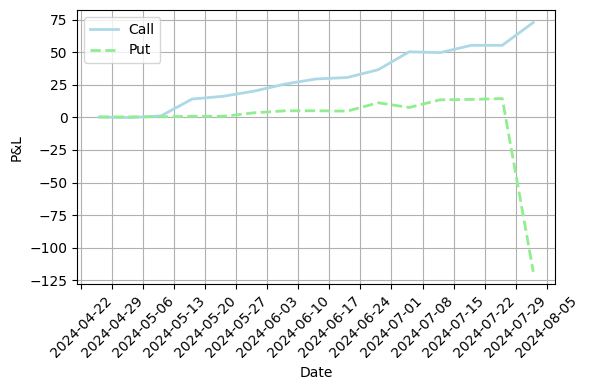

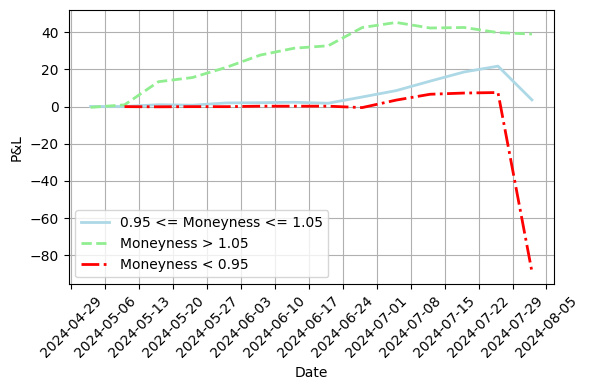

In [28]:
plot_delta(pnl_data[pnl_data['date'] >= pd.Timestamp(2024, 6, 1)])
plot_maturity_category(pnl_data[pnl_data['date'] >= pd.Timestamp(2024, 7, 1)])
plot_type_category(pnl_data)
plot_mness_category(pnl_data[pnl_data['Week'] > pnl_data['Week'].iloc[2]])

Analysis to find right threasholds for categorisation

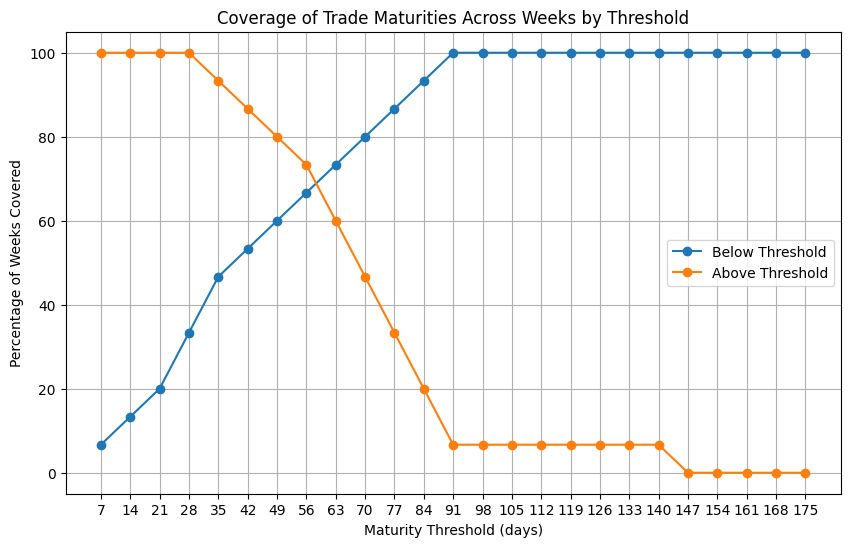

In [209]:
def analyze_threshold_coverage(data):
    thresholds = np.arange(7, 181, 7)  # Weekly increments from one week to about six months
    coverage_results = pd.DataFrame(index=thresholds, columns=['Below Coverage', 'Above Coverage'])

    # Group data by week
    weekly_groups = data.groupby('Week')

    # Analyze each threshold
    for threshold in thresholds:
        weeks_with_below = 0
        weeks_with_above = 0
        total_weeks = 0
        
        for name, group in weekly_groups:
            total_weeks += 1
            if any(group['time_to_maturity_days'] <= threshold):
                weeks_with_below += 1
            if any(group['time_to_maturity_days'] > threshold):
                weeks_with_above += 1
        
        # Calculate the percentage of weeks covered
        coverage_results.loc[threshold, 'Below Coverage'] = weeks_with_below / total_weeks * 100
        coverage_results.loc[threshold, 'Above Coverage'] = weeks_with_above / total_weeks * 100

    # Plotting the coverage results
    fig, ax = plt.subplots(figsize=(10, 6))
    coverage_results.plot(ax=ax, marker='o')
    ax.set_xticks(thresholds)
    ax.set_title('Coverage of Trade Maturities Across Weeks by Threshold')
    ax.set_xlabel('Maturity Threshold (days)')
    ax.set_ylabel('Percentage of Weeks Covered')
    ax.grid(True)
    ax.legend(['Below Threshold', 'Above Threshold'])
    plt.show()

analyze_threshold_coverage(pnl_data)


<Axes: xlabel='Week'>

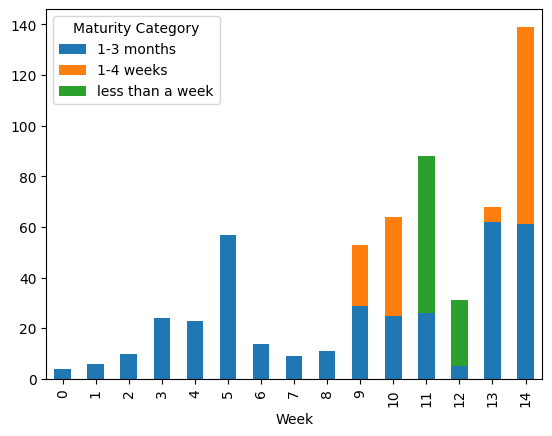

In [51]:
# show occuranve of each week for all maturity categoroes
pnl_data.groupby(['Week', 'Maturity Category']).size().unstack().plot(kind='bar', stacked=True)

<Axes: xlabel='Week'>

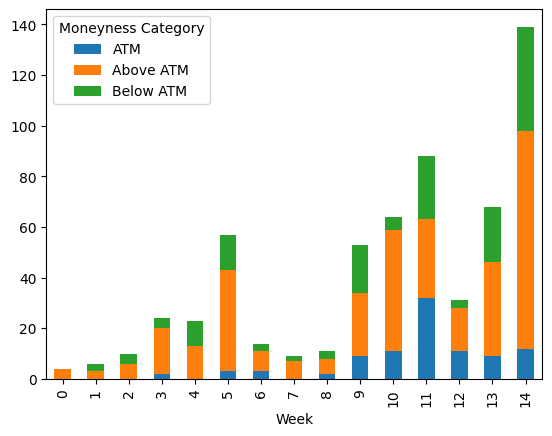

In [48]:
# show occuranve of each week for all moneyness categoroes
pnl_data.groupby(['Week', 'Moneyness Category']).size().unstack().plot(kind='bar', stacked=True)

<Axes: xlabel='time_to_maturity_days'>

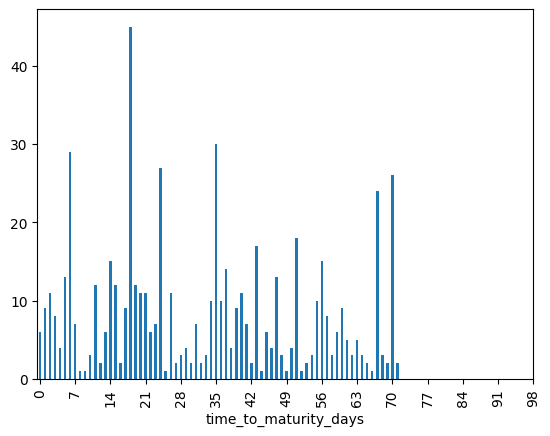

In [54]:
# show plot for all time_matuirty_days, x axiss range of 7 days
pnl_data.groupby(['time_to_maturity_days']).size().plot(kind='bar', stacked=True, xticks=range(0, 100, 7))

<Axes: xlabel='Week'>

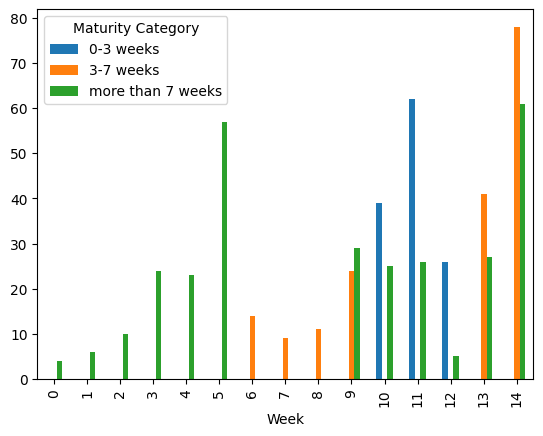

In [60]:
# plot of maturity categoroies for each week
pnl_data.groupby(['Week', 'Maturity Category']).size().unstack().plot(kind='bar')

<Axes: xlabel='Week'>

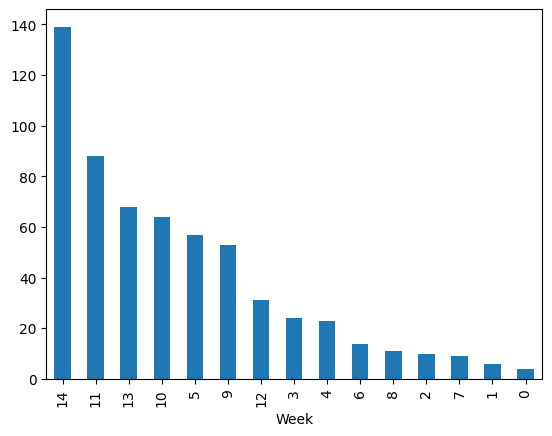

In [59]:
pnl_data['Week'].value_counts().plot(kind='bar')